# Linear Regression
Here we use the Linear Regression method on the converted data from the descriptive_analysis.ipynb.

https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import utils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.linear_model import LassoCV
from datetime import datetime, timedelta
np.random.seed(1)

In [2]:
test = pd.read_csv('./data/converted_test_2020_07_14_18-00-38.csv', index_col=0)
train = pd.read_csv('./data/converted_train_2020_07_14_18-00-38.csv', index_col=0)

In [3]:
# Check for nulls
print(train.isnull().values.any())
print(test.isnull().values.any())

False
False


In [4]:
trainFeatures = [['min_future_price_in_eur', 'Duration_Time', 'price_in_eur', 'flight_distance_km']]
for feature in trainFeatures:
    train[feature] = np.log1p(train[feature])

    
testFeatures = [['Duration_Time', 'price_in_eur', 'flight_distance_km']]
for feature in testFeatures:
    test[feature] = np.log1p(test[feature])
test

,Request_Date,Flight_Date,Duration_Time,Departure_hour,flight_unique_id,route_abb,flight_number,Price,Currency,price_in_eur,Request_Weekday,Request_timeofday,Departure_timeofday,flight_distance_km,Request_hour,Request_Date_Month,Flight_Date_Month,route_abb_from,route_abb_to
0,2019-06-03 11:00:00,2019-07-02 07:00:00,6.541030,7:00,2019-07-02 FR 145,STN-SXF,FR 145,26.87,£,3.211314,Monday,Morning,Morning,6.811465,11:00,6,7,STN,SXF
1,2019-06-03 23:00:00,2019-07-02 07:00:00,6.523562,7:00,2019-07-02 FR 145,STN-SXF,FR 145,39.46,£,3.582648,Monday,Night,Morning,6.811465,23:00,6,7,STN,SXF
2,2019-06-04 11:00:00,2019-07-02 07:00:00,6.505784,7:00,2019-07-02 FR 145,STN-SXF,FR 145,39.46,£,3.583964,Tuesday,Morning,Morning,6.811465,11:00,6,7,STN,SXF
3,2019-06-04 23:00:00,2019-07-02 07:00:00,6.487684,7:00,2019-07-02 FR 145,STN-SXF,FR 145,39.46,£,3.583964,Tuesday,Night,Morning,6.811465,23:00,6,7,STN,SXF
4,2019-06-05 11:00:00,2019-07-02 07:00:00,6.469250,7:00,2019-07-02 FR 145,STN-SXF,FR 145,39.46,£,3.582791,Wednesday,Morning,Morning,6.811465,11:00,6,7,STN,SXF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,2019-07-30 23:00:00,2019-08-02 22:00:00,4.276666,22:00,2019-08-02 FR 8545,SXF-STN,FR 8545,42.83,€,3.780319,Tuesday,Night,Night,6.811465,23:00,7,8,SXF,STN
5579,2019-07-31 11:00:00,2019-08-02 22:00:00,4.094345,22:00,2019-08-02 FR 8545,SXF-STN,FR 8545,50.99,€,3.951051,Wednesday,Morning,Night,6.811465,11:00,7,8,SXF,STN
5580,2019-07-31 23:00:00,2019-08-02 22:00:00,3.871201,22:00,2019-08-02 FR 8545,SXF-STN,FR 8545,50.99,€,3.951051,Wednesday,Night,Night,6.811465,23:00,7,8,SXF,STN
5581,2019-08-01 11:00:00,2019-08-02 22:00:00,3.583519,22:00,2019-08-02 FR 8545,SXF-STN,FR 8545,50.99,€,3.951051,Thursday,Morning,Night,6.811465,11:00,8,8,SXF,STN


In [5]:
# One Hot encoding for categorical values / Drop first category is a must for linear regression
train = pd.get_dummies(train, columns=['Request_Weekday', 'Request_timeofday', 'Departure_timeofday', 'route_abb_from', 'route_abb_to', 'Departure_hour'], drop_first=True)
test = pd.get_dummies(test, columns=['Request_Weekday', 'Request_timeofday', 'Departure_timeofday', 'route_abb_from', 'route_abb_to', 'Departure_hour'], drop_first=True)

In [6]:
# Add train column
test['train'] = 0
train['train'] = 1

# Equal columns across both tables
combined = pd.concat([train,test], sort=False)
train = combined[combined['train'] == 1]
test = combined[combined['train'] == 0]

# Fill NaN with 0
train = train.fillna(0)
test = test.fillna(0)

# Drop train column
test.drop(['train'], axis=1, inplace=True)
train.drop(['train'], axis=1, inplace=True)
test

,Request_Date,Flight_Date,Duration_Time,flight_unique_id,route_abb,flight_number,Price,Currency,min_future_price,price_in_eur,...,route_abb_to_STN,route_abb_to_SXF,Departure_hour_18:00,Departure_hour_19:00,Departure_hour_21:00,Departure_hour_22:00,Departure_hour_6:00,Departure_hour_7:00,Departure_hour_8:00,Departure_hour_9:00
0,2019-06-03 11:00:00,2019-07-02 07:00:00,6.541030,2019-07-02 FR 145,STN-SXF,FR 145,26.87,£,0.0,3.211314,...,0,1,0,0,0,0,0,1,0,0.0
1,2019-06-03 23:00:00,2019-07-02 07:00:00,6.523562,2019-07-02 FR 145,STN-SXF,FR 145,39.46,£,0.0,3.582648,...,0,1,0,0,0,0,0,1,0,0.0
2,2019-06-04 11:00:00,2019-07-02 07:00:00,6.505784,2019-07-02 FR 145,STN-SXF,FR 145,39.46,£,0.0,3.583964,...,0,1,0,0,0,0,0,1,0,0.0
3,2019-06-04 23:00:00,2019-07-02 07:00:00,6.487684,2019-07-02 FR 145,STN-SXF,FR 145,39.46,£,0.0,3.583964,...,0,1,0,0,0,0,0,1,0,0.0
4,2019-06-05 11:00:00,2019-07-02 07:00:00,6.469250,2019-07-02 FR 145,STN-SXF,FR 145,39.46,£,0.0,3.582791,...,0,1,0,0,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,2019-07-30 23:00:00,2019-08-02 22:00:00,4.276666,2019-08-02 FR 8545,SXF-STN,FR 8545,42.83,€,0.0,3.780319,...,1,0,0,0,0,1,0,0,0,0.0
5579,2019-07-31 11:00:00,2019-08-02 22:00:00,4.094345,2019-08-02 FR 8545,SXF-STN,FR 8545,50.99,€,0.0,3.951051,...,1,0,0,0,0,1,0,0,0,0.0
5580,2019-07-31 23:00:00,2019-08-02 22:00:00,3.871201,2019-08-02 FR 8545,SXF-STN,FR 8545,50.99,€,0.0,3.951051,...,1,0,0,0,0,1,0,0,0,0.0
5581,2019-08-01 11:00:00,2019-08-02 22:00:00,3.583519,2019-08-02 FR 8545,SXF-STN,FR 8545,50.99,€,0.0,3.951051,...,1,0,0,0,0,1,0,0,0,0.0


In [7]:
# Drop columns we do not need from train
train_dropped = train.drop(columns=['route_abb', 'min_future_price', 'Currency', 'flight_unique_id', 'Price', 'Request_Date', 'Flight_Date', 'Request_Date_Month', 'Flight_Date_Month', 'Request_hour', 'flight_number'])

# Drop columns we do not need from test
test_dropped = test.drop(columns=['route_abb', 'min_future_price', 'Currency', 'flight_unique_id', 'Price', 'min_future_price', 'min_future_price_in_eur', 'Request_Date', 'Flight_Date', 'Request_Date_Month', 'Flight_Date_Month', 'Request_hour', 'flight_number'])

In [8]:
# Generate test and target / Figure out which features to drop. 'min_future_price_in_eur' needs to be dropped!
X = train_dropped.drop(columns=['min_future_price_in_eur'])
y = train_dropped['min_future_price_in_eur'].values

In [9]:
test_dropped

,Duration_Time,price_in_eur,flight_distance_km,Request_Weekday_Monday,Request_Weekday_Saturday,Request_Weekday_Sunday,Request_Weekday_Thursday,Request_Weekday_Tuesday,Request_Weekday_Wednesday,Request_timeofday_Night,...,route_abb_to_STN,route_abb_to_SXF,Departure_hour_18:00,Departure_hour_19:00,Departure_hour_21:00,Departure_hour_22:00,Departure_hour_6:00,Departure_hour_7:00,Departure_hour_8:00,Departure_hour_9:00
0,6.541030,3.211314,6.811465,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0.0
1,6.523562,3.582648,6.811465,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0.0
2,6.505784,3.583964,6.811465,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0.0
3,6.487684,3.583964,6.811465,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,0.0
4,6.469250,3.582791,6.811465,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,4.276666,3.780319,6.811465,0,0,0,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0.0
5579,4.094345,3.951051,6.811465,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0.0
5580,3.871201,3.951051,6.811465,0,0,0,0,0,1,1,...,1,0,0,0,0,1,0,0,0,0.0
5581,3.583519,3.951051,6.811465,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0.0


# Feature importance

In [10]:
# Features with the highest absolute coef_ value are considered the most important
feature_names = X.columns
clf = LassoCV(cv=100).fit(X, y)
print(clf.score(X, y))
importance = np.abs(clf.coef_)
print(importance)

0.8641981237005127
[0.17022063 0.8280542  0.         0.02521027 0.         0.02370951
 0.         0.01365525 0.01140375 0.00472415 0.         0.016177
 0.         0.03889994 0.         0.03519848 0.04704068 0.
 0.         0.03107729 0.03859216 0.02270597 0.00094478 0.        ]


In [11]:
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01

idx_features = (-importance).argsort()[:4]
name_features = np.array(feature_names)[idx_features]
print('Selected features: {}'.format(name_features))

sfm = SelectFromModel(clf, threshold=threshold)
sfm.fit(X, y)
X_transform = sfm.transform(X)

n_features = sfm.transform(X).shape[1]

Selected features: ['price_in_eur' 'Duration_Time' 'Departure_hour_18:00'
 'route_abb_from_SXF']


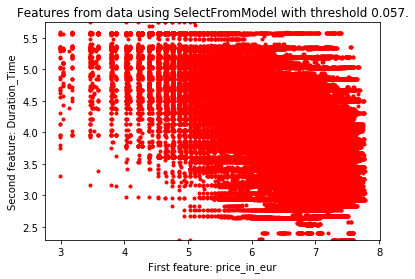

In [12]:
plt.title(
    "Features from data using SelectFromModel with "
    "threshold %0.3f." % sfm.threshold)
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1]
plt.plot(feature1, feature2, 'r.')
plt.xlabel("First feature: {}".format(name_features[0]))
plt.ylabel("Second feature: {}".format(name_features[1]))
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()

In [13]:
features = name_features
X = X[features]

# Build model

In [14]:
# Split dataset into train and test data (might want to try random_state=0 to randomize each calculation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((66899, 4), (66899,), (16725, 4), (16725,))

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_model = lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

In [16]:
print('coefficients')
print(lin_reg.intercept_)
list(zip(X.columns, lin_reg.coef_))
# For a given amount of price_in_eur,  ad spending, an increase of $1000 in TV ad spending is associated with an increase in Sales of 45.765 widgets.

coefficients
1.4928554647573513


[('price_in_eur', 0.8341432939604574),
 ('Duration_Time', -0.16850329276002465),
 ('Departure_hour_18:00', 0.058930470319986814),
 ('route_abb_from_SXF', 0.01561971814526475)]

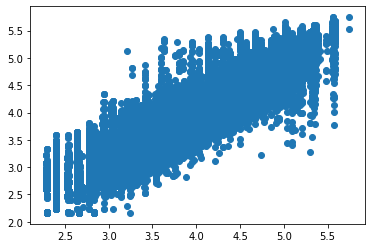

In [17]:
# Make cross validated predictions
predictions = cross_val_predict(lin_model, X, y, cv=6)
plt.scatter(y, predictions)

In [18]:
df_pred = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df_pred

,Actual,Predicted
0,4.079738,4.172796
1,5.184421,5.358150
2,2.840990,2.659993
3,5.093099,5.099795
4,3.753502,3.903857
...,...,...
16720,3.044046,2.973432
16721,4.805438,4.619769
16722,3.204777,2.975778
16723,3.791887,3.334093


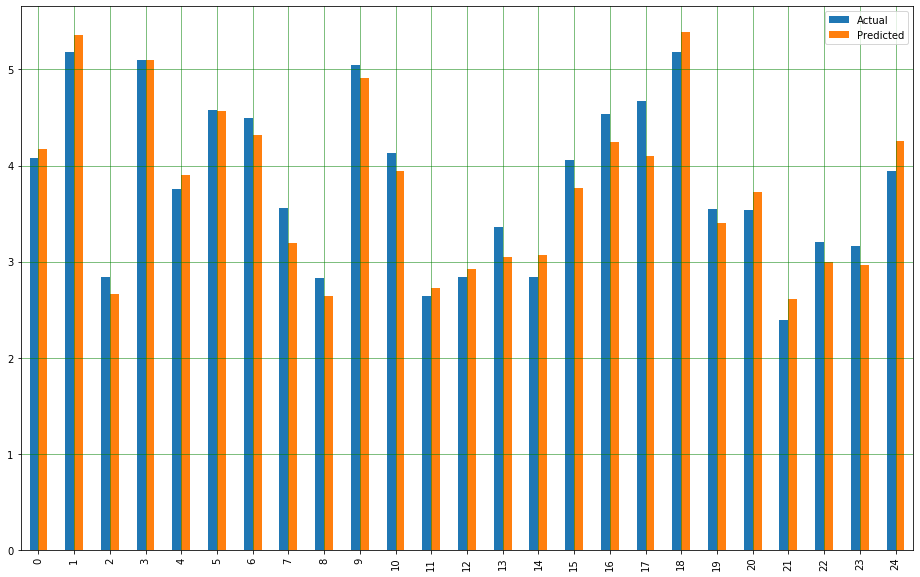

In [19]:
df_pred.head(25).plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Model Evaluation Metrics for Regression

In [20]:
print('Score:', lin_reg.score(X_test, y_test))

scores = cross_val_score(lin_model, X, y, cv=6)
print('Cross-validated scores:', scores)

Score: 0.8622658687675742
Cross-validated scores: [0.83345993 0.83340248 0.83070094 0.82640384 0.82179621 0.80635716]


In [21]:
# Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
# Lower values of RMSE indicate better fit
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# Root Mean Squared Error: 0.2697493287785844

Root Mean Squared Error: 0.27095920611592644


# Use on Test Data

In [22]:
test_pred = lin_reg.predict(np.array(test_dropped[features]))

In [23]:
final_pred = pd.DataFrame({'Request_Date': test['Request_Date'], 'flight_unique_id': test['flight_unique_id'], 'price_in_eur': np.exp(test['price_in_eur']), 'min_future_price_eur': np.exp(test_pred)})
final_pred

,Request_Date,flight_unique_id,price_in_eur,min_future_price_eur
0,2019-06-03 11:00:00,2019-07-02 FR 145,24.811657,21.528250
1,2019-06-03 23:00:00,2019-07-02 FR 145,35.968663,29.431208
2,2019-06-04 11:00:00,2019-07-02 FR 145,36.016015,29.551920
3,2019-06-04 23:00:00,2019-07-02 FR 145,36.016015,29.642188
4,2019-06-05 11:00:00,2019-07-02 FR 145,35.973793,29.705325
...,...,...,...,...
5578,2019-07-30 23:00:00,2019-08-02 FR 8545,43.830000,51.478806
5579,2019-07-31 11:00:00,2019-08-02 FR 8545,51.990000,61.209822
5580,2019-07-31 23:00:00,2019-08-02 FR 8545,51.990000,63.555154
5581,2019-08-01 11:00:00,2019-08-02 FR 8545,51.990000,66.711908


# Compute Buy False/True

In [27]:
final_pred['buy'] = np.nan
for index, row in final_pred.iterrows():
    if row.price_in_eur > row.min_future_price_eur:
        final_pred.set_value(index,'buy',0)
    else:
        final_pred.set_value(index,'buy',1)
print(final_pred)
# final_pred.to_csv('./data/linear_regression_test.csv', sep=',')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


            Request_Date    flight_unique_id  price_in_eur  \
0    2019-06-03 11:00:00   2019-07-02 FR 145     24.811657   
1    2019-06-03 23:00:00   2019-07-02 FR 145     35.968663   
2    2019-06-04 11:00:00   2019-07-02 FR 145     36.016015   
3    2019-06-04 23:00:00   2019-07-02 FR 145     36.016015   
4    2019-06-05 11:00:00   2019-07-02 FR 145     35.973793   
...                  ...                 ...           ...   
5578 2019-07-30 23:00:00  2019-08-02 FR 8545     43.830000   
5579 2019-07-31 11:00:00  2019-08-02 FR 8545     51.990000   
5580 2019-07-31 23:00:00  2019-08-02 FR 8545     51.990000   
5581 2019-08-01 11:00:00  2019-08-02 FR 8545     51.990000   
5582 2019-08-01 23:00:00  2019-08-02 FR 8545     51.990000   

      min_future_price_eur  buy  
0                21.528250  0.0  
1                29.431208  0.0  
2                29.551920  0.0  
3                29.642188  0.0  
4                29.705325  0.0  
...                    ...  ...  
5578             

# Optimization Performance
Das Vorhersagemodell für die Entscheidung Warten oder Kaufen eines Flugtickets soll hinsichtlich der Vorhersagegenauigkeit optimiert werden, d.h. 
Genauigkeit = Anzahl der richtigen Entscheidungen / Anzahl aller Entscheidungen. 

In [25]:
optimize_final_pred = final_pred
def getModelScore(data):
    data['Request_Date'] = pd.to_datetime(data['Request_Date'], format='%Y-%m-%d %H:%M:%S')
    decision_true_total = 0
    unique_flights_id = data['flight_unique_id'].unique()
    for element in unique_flights_id:
        flights = data[data['flight_unique_id'] == element].sort_values('Request_Date', ascending=False)
        for index, flight in flights.iterrows():
            filtered_flights = flights[flights['Request_Date'] >= flight.Request_Date].sort_values('Request_Date', ascending=False)
            if flight.buy == 1:
                filtered_flights = filtered_flights[filtered_flights['price_in_eur'] < flight.price_in_eur]
            if flight.buy == 0:
                filtered_flights = filtered_flights[filtered_flights['price_in_eur'] > flight.price_in_eur]
            if len(filtered_flights) == 0:
                decision_true_total = decision_true_total + 1
    print('True: ' + str(decision_true_total))
    print('Total: ' + str(len(data)))
    return decision_true_total/len(data)

getModelScore(optimize_final_pred)
# 478 'price_in_eur' 'Duration_Time' 'Departure_hour_18:00' 'route_abb_from_SXF'

True: 478
Total: 5583


0.08561705176428444

In [26]:
check_final_pred = final_pred
def checkDateToBuy(data, flight_unique_id, request_date):
    flights = data[data['flight_unique_id'] == flight_unique_id].sort_values('Request_Date', ascending=False)
    price_saving = 0
    if request_date <= flights.iloc[0].Request_Date:
        flights['Request_Date'] = pd.to_datetime(flights['Request_Date'], format='%Y-%m-%d %H:%M:%S')
        flights = flights[flights['Request_Date'] > request_date].sort_values('Request_Date', ascending=True)
        initialPrice = 0
        flights = flights.reset_index()
        for index, flight in flights.iterrows():
            if index == 0:
                initialPrice = flight.price_in_eur
            if flight.buy == 1:
                price_saving = initialPrice - flight.price_in_eur
                return [request_date, price_saving, flight.Request_Date]
        return 0
    else:
        print('No data available for the supplied Request_Date')

checkDateToBuy(check_final_pred, '2019-07-02 FR 145', datetime(2019, 5, 1))

[datetime.datetime(2019, 5, 1, 0, 0),
 -26.35706309999999,
 Timestamp('2019-06-26 11:00:00')]

Die Optimierung geschieht nur auf den Trainingsdaten über Kreuzvalidierung.
Wir definieren ein weiteres Maß für die Modellgüte, um die potentielle Geldersparnis durch das Modell zu messen. Dem Vorschlag von Gruppe 2(?) folgend gehen wir von folgender Idee aus:

a) Wir suchen uns einen Flug aus (flight_unique_id), für den wir ein Ticket kaufen möchten

b) Zu einem Zeitpunkt (Request_Date) prüfen wir zum ersten Mal den Preis

c) Wir fragen das Modell, ob wir warten oder kaufen sollen

d) Wenn das Modell empfiehlt zu kaufen, dann kaufen wir das Ticket; weiter bei Schritt f)

e) Wenn das Modell empfiehlt zu warten, dann gehen wir zur zum nächsten Request_Date des Fluges und zurück zu Schritt c); Wenn es keinen nächsten Request_Date für den Flug mehr gibt (letzte Preisabfrage vor Abflug), dann kaufen wir ein Ticket zum aktuellen Preis, egal was es kostet.

f) Wir bestimmen die Differenz zwischen Kaufpreis (Price) und optimalem zukünftigen Preis (min_future_price).



Um die Modellgüte basierend auf dieser Idee zu messen, führen wir das Protokoll oben für jedes Request_Date in b) aus und addieren so die Differenzen aus f) für jeden Flug (flight_unique_id) auf. Diese Summen addieren wir über alle Flüge auf.

Eine effiziente Implementierung wäre, für einen Flug mit dem letzten Request_Date vor dem Abflug zu beginnen und sich dann schrittweise über Request_Date in die Vergangenheit vorzuarbeiten. Beim letzten Request_Date vor Abflug muss ein Ticket gekauft werden, egal was die Empfehlung des Modells ist.

Wenn wir einen Schritt in die Vergangenheit gehen und die Kaufempfehlung dort "warten" ist, dann berechnen wir die Preisdifferenz zum Schritt davor. Wenn die Kaufempfehlung "kaufen" ist, dann berechnen wir die Differenz zwischen Kaufpreis (Price) und optimalem zukünftigen Preis (min_future_price) wie in f).

Wir gehen wieder einen Schritt in die Vergangenheit und handeln/rechnen wie zuvor bis wir die erste Preisabfrage für den Flug erreicht haben.

Auf den Testdaten werden wir die Genauigkeit aus 1. und das Gütemaß aus 3. bestimmen.
Es ist nicht erlaubt, für die Testdaten min_future_price zu berechnen, um die Güte des Modells zu verbessern. Aus Gründen der Fairness möchte ich Sie bitten, hier nicht zu mogeln. Sie dürfen aber für die Testdaten die zusätzlichen Merkmale (Features) berechnen, welche Sie sich für das Modell überlegt haben. Achten Sie dabei bitte darauf, dass Sie keine Informationen aus der Zukunft verwenden, die Sie im Fall einer praktischen Anwendung nicht hätten.
Bedenken Sie beim Bau Ihres Modells, dass Sie ein Ticket kaufen müssen, wenn Sie in den Daten das letzte Request_Date vor Abflug erreicht haben. Wir gehen davon aus, dass wir die Information "letztes Request_Date vor Abflug" bei der Preisabfrage kennen. Sie können dies also den Daten zufügen.
Ich habe das Problem in den Daten behoben, dass für einige Flüge min_future_price scheinbar nicht gestimmt hat. Dies lag daran, dass die letzten Preisabfragen in der Datenaufbereitung fälschlicherweise gelöscht wurden. Weiterhin habe ich die Testdaten neu ausgewählt. Benutzen Sie also bitte die aktuellen Daten in Moodle (ab 17.6. verfügbar).
Das Modell für den Entscheidungsprozess aus 3. zu optimieren ist deutlich schwieriger als der Standard aus 1. Für die Bewertung der Arbeit mit einer 1.0 erwarte ich wenigstens eine ansatzweise Implementierung der Optimierung nach 3., für eine 1.3 wenigstens die gute Beschreibung eines Lösungsansatzes. Eine saubere Bearbeitung der anderen Teile ist natürlich trotzdem grundlegende Voraussetzung.